# continuation of energy prediction
Load libraries, read in prepared prediction dataset and continue

1. [Understand Feature Interactions](#Interactions)
    * [buidlings file correlations](#Correlations)
    * [reorder columns, handle skew, scale and polynomial expansion](#FeaturePrep)
2. [Develop | Run Models](#Models)
    * linear regression (simple)
    * linear with train / test
    * decision tree (simple)
    * random forest
    * random forest with cross validation
3. [Evaluate Models](#Evaluation)

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans,DBSCAN
from sklearn.externals.six import StringIO
from sklearn.cross_validation import KFold, cross_val_score

# visualization
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
#plt.style.use('default')
plt.style.use('fivethirtyeight')
from IPython.display import Image
import pydotplus
from sklearn.tree import export_graphviz

np.set_printoptions(precision=4,suppress=True)

C:\Users\Peter\Anaconda3\envs\metis\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
raw_path = '../PG_Project/'
buildingsPredictFinal = pd.read_csv(raw_path+'buildingsPredictFinal.csv', index_col=0)

<a id='Interactions'></a>
## ** Feature Interactions **
 
<a id='Correlations'></a>
### ** Feature Correlation **

Original buildings corr matrix shape: (12L, 12L)
The correlation matrix for the buildings dataset:


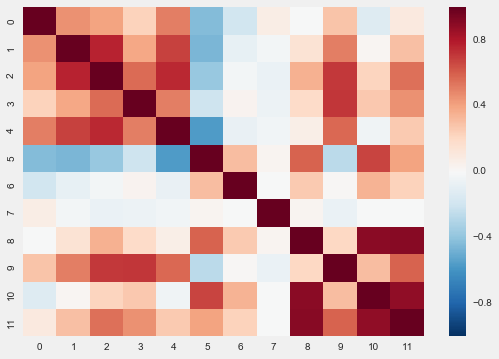

In [3]:
# look briefly at correlations in the new dataset
buildings_corr = buildingsPredictFinal[["Stories","BldgGrade","SqFtTotLiving","Bedrooms",
                            "BathCountFinal","Age","Condition","DegreeDays",
                            "HEATING","BASELOAD","COOLING","TOTAL_COST"]]
buildings_corr_final = np.corrcoef(buildings_corr.T)
print "Original buildings corr matrix shape:",buildings_corr_final.shape
sns.heatmap(buildings_corr_final)
print "The correlation matrix for the buildings dataset:"

### correlation notes
1. we see moderate positive correlation between 2, 3, 5 and 11 (our target "TOTAL_COST")
2. 2, 3, and 5 are "SqFtTotLiving","Bedrooms","Age"
3. "Age" has a strong correlation with "cooling" (the older the building the higher the cooling)
4. "SqFtTotLiving","Bedrooms" are strongly correlated with "BASELOAD"
5. "BldgGrade","Age" are moderately correlated with "BASELOAD"
6. "Age" is moderately anti-correlated with "BASELOAD"
7. "DegreeDays" doesn't seem correlated at all - which is odd

<a id='FeaturePrep'></a>
### ** Feature Preparation **
#### ** Column Ordering by Type **

In [4]:
# create new dataframe that reorders and drops unneeded columns
buildingsColumns = buildingsPredictFinal.columns.tolist()
buildingsColumnsUse = buildingsColumns[0:1]+buildingsColumns[2:6]+buildingsColumns[25:26]+buildingsColumns[1:2]+buildingsColumns[7:8]+buildingsColumns[9:22]+buildingsColumns[35:]
buildingsPredictData = buildingsPredictFinal[buildingsColumnsUse].copy()


#### Set variables to control feature use and observation counts

In [5]:
samplesCount = 20000
buildingColumns = buildingsPredictData.columns.tolist()
buildingTarget = buildingColumns[-1]
buildingFeatures = buildingColumns[0:-1]
buildingFeaturesCat = buildingColumns[8:21]
buildingFeaturesNum = buildingColumns[0:8] 
buildingFeaturesScaleSkew = buildingColumns[0:6]
print "target column is: \n", buildingTarget

print "\nfeature columns are:  \n", buildingFeatures

print "\ncategorical features are:  \n", buildingFeaturesCat

print "\nnumerical features are:  \n", buildingFeaturesNum

print "\nscale-skew features are: \n", buildingFeaturesScaleSkew

target column is: 
TOTAL_COST

feature columns are:  
['Stories', 'SqFtTotLiving', 'Bedrooms', 'BathCountFinal', 'Age', 'DegreeDays', 'BldgGrade', 'Condition', 'HeatSource_1', 'HeatSource_2', 'HeatSource_3', 'HeatSource_4', 'HeatSource_5', 'HeatSource_6', 'HeatSystem_1', 'HeatSystem_2', 'HeatSystem_3', 'HeatSystem_4', 'HeatSystem_5', 'HeatSystem_6', 'HeatSystem_7']

categorical features are:  
['HeatSource_1', 'HeatSource_2', 'HeatSource_3', 'HeatSource_4', 'HeatSource_5', 'HeatSource_6', 'HeatSystem_1', 'HeatSystem_2', 'HeatSystem_3', 'HeatSystem_4', 'HeatSystem_5', 'HeatSystem_6', 'HeatSystem_7']

numerical features are:  
['Stories', 'SqFtTotLiving', 'Bedrooms', 'BathCountFinal', 'Age', 'DegreeDays', 'BldgGrade', 'Condition']

scale-skew features are: 
['Stories', 'SqFtTotLiving', 'Bedrooms', 'BathCountFinal', 'Age', 'DegreeDays']


#### Create "samples" file to work on (dataset too big for my machine)


In [6]:
buildingSamp = buildingsPredictData.head(samplesCount).copy()

## Target Summary
#### We can see that 50% of all values fall within a 450 dollar range.

In [7]:
buildingsPredictData[buildingTarget].describe()

count    480685.000000
mean       1499.096554
std         402.228996
min         168.795444
25%        1231.985359
50%        1430.823512
75%        1680.517046
max        9532.973466
Name: TOTAL_COST, dtype: float64

## Categorical Summary
* we may not use any of these columns in our model

In [8]:
# our categoricals are all 0 / 1 values
#  we can see by the means that the columns are very unbalanced

buildingsPredictData[buildingFeaturesCat].describe()

,HeatSource_1,HeatSource_2,HeatSource_3,HeatSource_4,HeatSource_5,HeatSource_6,HeatSystem_1,HeatSystem_2,HeatSystem_3,HeatSystem_4,HeatSystem_5,HeatSystem_6,HeatSystem_7
count,480685.000000,480685.000000,480685.000000,480685.000000,480685.000000,480685.000000,480685.000000,480685.000000,480685.000000,480685.000000,480685.000000,480685.000000,480685.000000
mean,0.160615,0.676391,0.160105,0.000173,0.001073,0.000574,0.033117,0.003208,0.012297,0.075326,0.819154,0.026213,0.029816
std,0.367175,0.467853,0.366704,0.013139,0.032746,0.023955,0.178943,0.056548,0.110208,0.263917,0.384891,0.159767,0.170079
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Numericals summary

In [9]:
# there are no crazy outliers here, but we need to address skew and scale
buildingsPredictData[buildingFeaturesNum].describe()

,Stories,SqFtTotLiving,Bedrooms,BathCountFinal,Age,DegreeDays,BldgGrade,Condition
count,480685.000000,480685.000000,480685.000000,480685.000000,480685.000000,480685.000000,480685.000000,480685.000000
mean,1.431840,2059.900900,3.339561,2.362196,46.902608,5713.677053,7.570769,3.361172
std,0.508471,936.078975,0.926136,0.982832,27.873731,428.372826,1.178647,0.594910
min,1.000000,3.000000,1.000000,1.000000,1.000000,4853.000000,1.000000,1.000000
25%,1.000000,1410.000000,3.000000,2.000000,24.000000,5336.000000,7.000000,3.000000
50%,1.000000,1900.000000,3.000000,2.000000,44.000000,5728.000000,7.000000,3.000000
75%,2.000000,2510.000000,4.000000,3.000000,65.000000,6065.000000,8.000000,4.000000
max,5.000000,48160.000000,58.000000,24.000000,117.000000,6898.000000,20.000000,5.000000


## Fix Skew
* we are going to exclude the "ordered" numericals BldgGrade and Condition since we don't know the distance between values.
* all of the other values are ordered numericals where the distance between values is constant

NOTE: we'll fix skew on the full dataset and then recreate our sample

In [10]:
# evaluate skew
# buildingSkew = stats.skew(buildingsPredictData[buildingFeaturesScaleSkew])
buildingSkews = buildingsPredictData[buildingFeaturesScaleSkew].skew()
skew_cols = buildingSkews[np.abs(buildingSkews)>0.4].index.tolist()
print skew_cols
print buildingSkews

['Stories', 'SqFtTotLiving', 'Bedrooms', 'BathCountFinal', 'Age']
Stories           0.686651
SqFtTotLiving     2.054299
Bedrooms          1.362932
BathCountFinal    0.558046
Age               0.484615
DegreeDays        0.122491
dtype: float64


In [11]:
# fix skew on a copy of the data for merge back in
buildingPredictSkew = buildingsPredictData[skew_cols].copy()
buildingPredictSkew[skew_cols] = np.log(buildingPredictSkew[skew_cols])
buildingPredictSkew.tail()

,Stories,SqFtTotLiving,Bedrooms,BathCountFinal,Age
NEW_KEY,,,,,
703770,0.693147,7.258412,1.098612,0.693147,0.693147
703771,0.693147,7.258412,1.098612,0.693147,0.693147
703772,0.693147,7.258412,1.098612,0.693147,0.693147
704319,0.693147,7.272398,1.098612,1.098612,2.302585
704455,0.000000,7.218910,1.098612,0.000000,4.127134


In [12]:
#merge back in
buildingsPredictData[skew_cols] = buildingPredictSkew[skew_cols]
buildingsPredictData.tail()

,Stories,SqFtTotLiving,Bedrooms,BathCountFinal,Age,DegreeDays,BldgGrade,Condition,HeatSource_1,HeatSource_2,...,HeatSource_5,HeatSource_6,HeatSystem_1,HeatSystem_2,HeatSystem_3,HeatSystem_4,HeatSystem_5,HeatSystem_6,HeatSystem_7,TOTAL_COST
NEW_KEY,,,,,,,,,,,,,,,,,,,,,
703770,0.693147,7.258412,1.098612,0.693147,0.693147,5647,8,3,0,0,...,0,0,0,0,0,0,0,0,1,853.681898
703771,0.693147,7.258412,1.098612,0.693147,0.693147,5647,8,3,0,0,...,0,0,0,0,0,0,0,0,1,853.681898
703772,0.693147,7.258412,1.098612,0.693147,0.693147,5647,8,3,0,0,...,0,0,0,0,0,0,0,0,1,853.681898
704319,0.693147,7.272398,1.098612,1.098612,2.302585,5174,7,3,0,1,...,0,0,0,0,0,0,1,0,0,1008.505075
704455,0.000000,7.218910,1.098612,0.000000,4.127134,4962,6,4,0,1,...,0,0,0,0,0,0,1,0,0,1298.457955


## Scale the Data

In [13]:
# run Zscoring on select features to adjust scale.
scalex = StandardScaler()

buildingScaledFull = buildingsPredictData.copy()
buildingScaledFull[buildingFeaturesScaleSkew] = scalex.fit_transform(buildingScaledFull[buildingFeaturesScaleSkew])

In [14]:
buildingScaledFull.TOTAL_COST = buildingScaledFull.TOTAL_COST.astype(int)
buildingScaledFull["total_cost_bins"] = pd.cut(buildingScaledFull[buildingTarget],15) #create 15 equally-sized bins

In [15]:
# pairplot the entire feature set - visually identify a skewed distribution
#sns.pairplot(buildingSamp[buildingFeaturesScaleSkew[0:3]])

In [16]:
#sns.pairplot(buildingScaled[buildingFeaturesNum[0:7]+['total_cost_bins']]
#             ,hue='total_cost_bins', palette='coolwarm')

In [17]:
# see single column linear regression to our target value
#sns.pairplot(buildingScaled, x_vars=[buildingFeaturesNum[0:3]],
#             y_vars=buildingScaled.TOTAL_COST, size=6, aspect=0.8, kind='reg')

## Polynomial features setup

In [18]:
### get random sample before creating polynomials to preserve order with X on the random sample
buildingScaled = buildingScaledFull.sample(n=samplesCount)

In [19]:
feature_cols_names = buildingScaled[buildingFeaturesNum].columns.tolist()
poly2_interact = PolynomialFeatures(degree=2,interaction_only=True)
#don't want the initial constant term, so only keep columns 1 to the end
interactionsOnly_buildingNumeric = poly2_interact.fit_transform(buildingScaled[feature_cols_names])[:,1:]

# grab the categorical features (one hot encoded)
buildingNumeric_encoded = buildingScaled[buildingFeaturesCat]

# concatenate all input features
buildingPolynomial = np.concatenate((interactionsOnly_buildingNumeric,buildingNumeric_encoded.values),axis=1)

Xp = buildingPolynomial
yp = buildingScaled[buildingTarget]

# instantiate and fit
linp = LinearRegression()
linp.fit(Xp, yp)

# print the coefficients

print linp.intercept_
print linp.coef_

ylinp_pred = linp.predict(Xp)
#print ylin_pred
print metrics.r2_score(yp, ylinp_pred)

print "RMSE for TOTAL_COST:",np.sqrt(metrics.mean_squared_error(yp, ylinp_pred))

2521.0700158
[ 112.1787   24.218   245.9365  -49.7062 -257.8909  -81.9174 -123.7001
 -307.4393   19.6755   18.4845  -45.2648  -18.3525   12.3188   -9.0727
    0.3048   55.522    10.6465   97.5335   -0.6146   37.9772    1.5024
    9.2271   29.9916   -1.7943  -21.1902   -9.7361  -78.1177    2.8069
  -18.1877   50.3223   30.9321  -23.9381  225.4509   12.2547   -0.2548
   28.9944   10.1898   -6.8882  -34.8446  -50.7296  -21.8106  -78.8827
  112.6766  246.3118  126.2511  118.4693  108.1548  212.1373  105.4541]
0.765891226225
RMSE for TOTAL_COST: 194.72320459


In [20]:
print buildingPolynomial.shape
print interactionsOnly_buildingNumeric.shape
print buildingScaled.shape

(20000L, 49L)
(20000L, 36L)
(20000, 23)


## setup for models

In [21]:
# for standard (non - polynomial)
feature_cols = buildingScaled[buildingFeaturesNum]
X = feature_cols
y = buildingScaled[buildingTarget]



In [22]:
# output for Alteryx
buildingScaled.to_csv(raw_path+'buildingScaledUnSkewed.csv')

In [23]:
# train / test standard
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# train / test polynomial
Xp_train, Xp_test, yp_train, yp_test = train_test_split(Xp, yp, test_size=0.2)

print "training data size:",X_train.shape
print "testing data size:",X_test.shape
print "training data size - poly:",Xp_train.shape
print "testing data size - poly:",Xp_test.shape

training data size: (16000, 8)
testing data size: (4000, 8)
training data size - poly: (16000L, 49L)
testing data size - poly: (4000L, 49L)


<a id='Models'></a>
## ** Dev / Run Models **
### Linear Regression

In [24]:
# instantiate and fit
lin1 = LinearRegression()
lin1.fit(X, y)

# print the coefficients

print lin1.intercept_
print lin1.coef_

ylin_pred = lin1.predict(X)
#print ylin_pred
metrics.r2_score(y, ylin_pred)

1475.88785012
[  74.0263  300.9645   28.3726  -35.8423  265.7468    6.7692   -7.9233
   24.7621]


0.64970411052178689

In [25]:
zip(X, lin1.coef_)

[('Stories', 74.026299585896282),
 ('SqFtTotLiving', 300.96449737471158),
 ('Bedrooms', 28.372646955145598),
 ('BathCountFinal', -35.842340254688885),
 ('Age', 265.74682122383587),
 ('DegreeDays', 6.7691943191767692),
 ('BldgGrade', -7.9233387483510347),
 ('Condition', 24.762085001760763)]

In [26]:
print "RMSE for TOTAL_COST:",np.sqrt(metrics.mean_squared_error(y, ylin_pred))

RMSE for TOTAL_COST: 238.19156817


### Linear with Train / Test split

In [27]:
#train on training set
lin2= LinearRegression()
lin2.fit(X_train, y_train)
lin2p= LinearRegression()
lin2p.fit(Xp_train, yp_train)

#generate predictions on training set and evaluate
y_pred_train = lin2.predict(X_train)
print "Training set RMSE:",np.sqrt(metrics.mean_squared_error(y_train, y_pred_train))
yp_pred_train = lin2p.predict(Xp_train)
print "Training set RMSE - poly:",np.sqrt(metrics.mean_squared_error(yp_train, yp_pred_train))

#generate predictions on test set and evaluate
y_pred_test = lin2.predict(X_test)
print "Test set RMSE:",np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))
yp_pred_test = lin2p.predict(Xp_test)
print "Test set RMSE - poly:",np.sqrt(metrics.mean_squared_error(yp_test, yp_pred_test))

print "Test set R2:",metrics.r2_score(y_test, y_pred_test)
print "Test set R2 - poly:",metrics.r2_score(yp_test, yp_pred_test)

Training set RMSE: 232.365577917
Training set RMSE - poly: 196.146552222
Test set RMSE: 260.306955145
Test set RMSE - poly: 189.648219545
Test set R2: 0.61487920853
Test set R2 - poly: 0.776303165487


### There is non-linearity in the data.  Polynomial features return better results

### Decision Tree

In [28]:
decision_tree = DecisionTreeRegressor(max_depth=6)
decision_tree.fit(X_train,y_train)
y_test_predict = decision_tree.predict(X_test)
print "Decision Tree RMSE:",np.sqrt(
    mean_squared_error(y_test,
                       y_test_predict))

decision_treep = DecisionTreeRegressor(max_depth=6)
decision_treep.fit(Xp_train,yp_train)
yp_test_predict = decision_treep.predict(Xp_test)
print "Decision Tree RMSE - poly:",np.sqrt(
    mean_squared_error(yp_test,
                       yp_test_predict))

Decision Tree RMSE: 168.422703639
Decision Tree RMSE - poly: 146.498431468


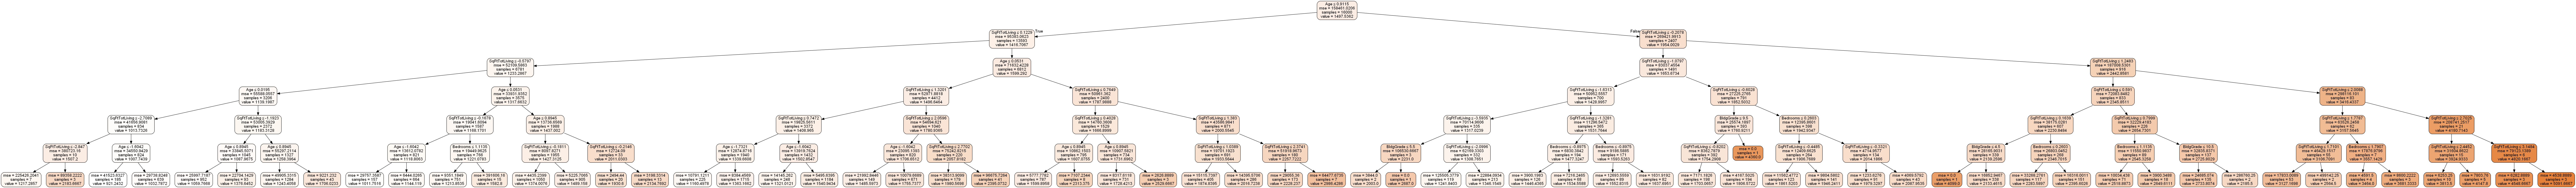

In [29]:
# tree for standard
dot_data = StringIO()  
export_graphviz(decision_tree, out_file=dot_data,  
                    feature_names=X_train.columns.tolist(),  
                    filled=True, rounded=True,  
                    special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  

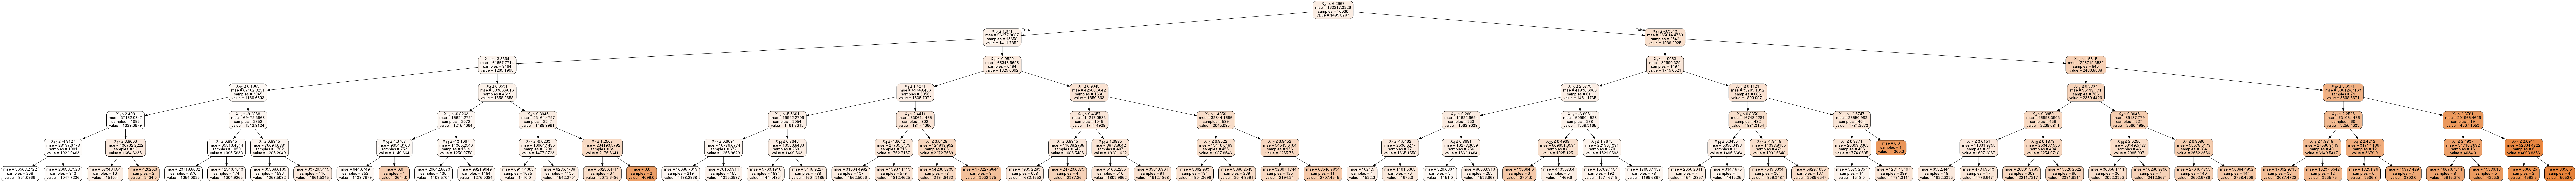

In [30]:
# tree for polynomial
## I have no idea how to label the columns...
dot_data = StringIO()  
export_graphviz(decision_treep, out_file=dot_data,  
                    #feature_names=buildingFeatures,  
                    filled=True, rounded=True,  
                    special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  

Decision Tree Train/Test RMSE: 348.661789789   368.161168158
Decision Tree Train/Test RMSE: 266.507953494   295.680376718
Decision Tree Train/Test RMSE: 223.261708919   251.534530765
Decision Tree Train/Test RMSE: 173.860478972   205.852937711
Decision Tree Train/Test RMSE: 150.058391385   183.891665356
Decision Tree Train/Test RMSE: 130.271788853   168.422703639
Decision Tree Train/Test RMSE: 116.344163061   159.384157516
Decision Tree Train/Test RMSE: 101.475501516   160.760559659
Decision Tree Train/Test RMSE: 86.0229382573   160.80531202
Decision Tree Train/Test RMSE: 72.5046147765   172.747232747
Decision Tree Train/Test RMSE: 52.819089021   187.231167159
Decision Tree Train/Test RMSE: 43.0532210667   188.855540841
Decision Tree Train/Test RMSE: 35.6566986309   187.481458845
Decision Tree Train/Test RMSE: 25.2243554251   208.144152488
Decision Tree Train/Test RMSE: 20.8892880909   196.214479941
Decision Tree Train/Test RMSE: 17.1141585408   194.718852786
Decision Tree Train/Test R

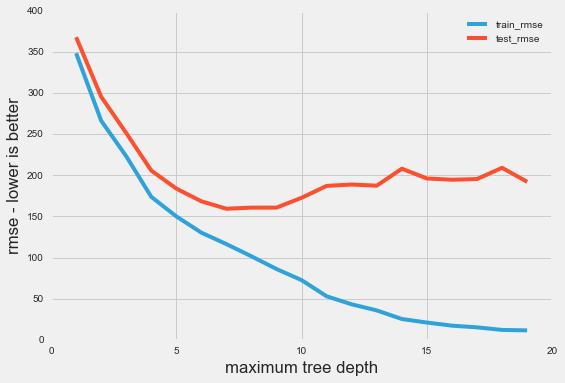

In [31]:
# test for optimal tree depth - STANDARD. 
# data suggest 7 - 10
depths = range(1,20)
train_rmse, test_rmse = [],[]
for depth in depths:
    decision_tree = DecisionTreeRegressor(max_depth=depth,random_state=1)
    decision_tree.fit(X_train,y_train)
    curr_train_rmse = np.sqrt(mean_squared_error(y_train,decision_tree.predict(X_train)))
    curr_test_rmse = np.sqrt(mean_squared_error(y_test,decision_tree.predict(X_test)))
    print "Decision Tree Train/Test RMSE:",curr_train_rmse," ",curr_test_rmse
    train_rmse.append(curr_train_rmse)
    test_rmse.append(curr_test_rmse)
plt.plot(depths,train_rmse,label='train_rmse')
plt.plot(depths,test_rmse,label='test_rmse')
plt.xlabel("maximum tree depth")
plt.ylabel("rmse - lower is better")
plt.legend()

In [32]:
best_single_tree = DecisionTreeRegressor(max_depth=9)
best_single_tree.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=9, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [33]:
# feature importance
pd.DataFrame({'feature':feature_cols_names, 'importance':best_single_tree.feature_importances_})

,feature,importance
0,Stories,0.001471
1,SqFtTotLiving,0.590259
2,Bedrooms,0.022289
3,BathCountFinal,0.001215
4,Age,0.372151
5,DegreeDays,0.003809
6,BldgGrade,0.006844
7,Condition,0.001962


Decision Tree Train/Test RMSE: 347.817059168   342.615916345
Decision Tree Train/Test RMSE: 273.202127104   268.554059028
Decision Tree Train/Test RMSE: 229.087748236   225.525343508
Decision Tree Train/Test RMSE: 187.327969078   182.201290878
Decision Tree Train/Test RMSE: 161.651941069   162.537372111
Decision Tree Train/Test RMSE: 139.194885103   146.30128271
Decision Tree Train/Test RMSE: 123.623018435   139.446658391
Decision Tree Train/Test RMSE: 110.23076932   148.135411016
Decision Tree Train/Test RMSE: 87.2904157973   164.480187016
Decision Tree Train/Test RMSE: 78.7402510254   164.498858202
Decision Tree Train/Test RMSE: 65.8166186176   161.485859945
Decision Tree Train/Test RMSE: 40.3880531187   160.171695122
Decision Tree Train/Test RMSE: 31.2093286666   165.680703454
Decision Tree Train/Test RMSE: 24.9088515236   166.46967445
Decision Tree Train/Test RMSE: 20.4657535277   165.39946208
Decision Tree Train/Test RMSE: 17.2162483844   164.691985814
Decision Tree Train/Test RMS

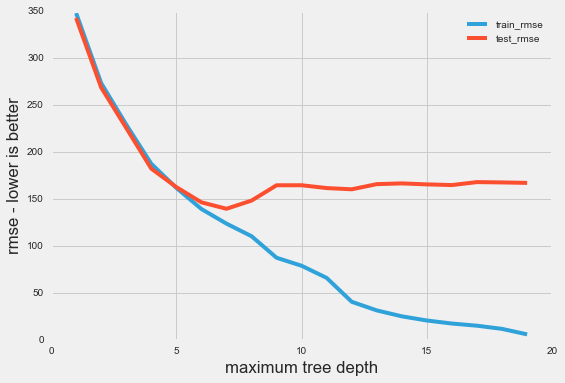

In [34]:
# test for optimal tree depth - POLYNOMIAL. 
# data suggest 8 - 11
depths = range(1,20)
train_rmsep, test_rmsep = [],[]
for depth in depths:
    decision_treep = DecisionTreeRegressor(max_depth=depth,random_state=1)
    decision_treep.fit(Xp_train,yp_train)
    curr_train_rmsep = np.sqrt(mean_squared_error(yp_train,decision_treep.predict(Xp_train)))
    curr_test_rmsep = np.sqrt(mean_squared_error(yp_test,decision_treep.predict(Xp_test)))
    print "Decision Tree Train/Test RMSE:",curr_train_rmsep," ",curr_test_rmsep
    train_rmsep.append(curr_train_rmsep)
    test_rmsep.append(curr_test_rmsep)
plt.plot(depths,train_rmsep,label='train_rmse')
plt.plot(depths,test_rmsep,label='test_rmse')
plt.xlabel("maximum tree depth")
plt.ylabel("rmse - lower is better")
plt.legend()

In [35]:
best_single_treep = DecisionTreeRegressor(max_depth=9)
best_single_treep.fit(Xp_train, yp_train)

DecisionTreeRegressor(criterion='mse', max_depth=9, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [36]:
poly_cols_names = Xp.dtype.names

In [37]:
# feature importance
# pd.DataFrame({'feature':poly_cols_names, 'importance':best_single_treep.feature_importances_})

### Random Forest

In [38]:
rf = RandomForestRegressor(n_estimators=200,
                            bootstrap=True,
                            max_features=6,
                            oob_score=True,
                            max_depth=9)

rf.fit(X_train,y_train)
y_pref_rf = rf.predict(X_test)
preds = rf.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test,preds))
print "RMSE on test set:",rmse

RMSE on test set: 149.235582287


In [39]:
pd.DataFrame({'feature':feature_cols_names, 'importance':rf.feature_importances_}).sort_values(by='importance',ascending=False)

,feature,importance
1,SqFtTotLiving,0.498020
4,Age,0.385959
2,Bedrooms,0.061526
6,BldgGrade,0.021200
3,BathCountFinal,0.017283
5,DegreeDays,0.006548
7,Condition,0.005252
0,Stories,0.004211


### DegreeDays not very important

In [40]:
rfp = RandomForestRegressor(n_estimators=200,
                            bootstrap=True,
                            max_features=6,
                            oob_score=True,
                            max_depth=9)

rfp.fit(Xp_train,yp_train)
yp_pref_rfp = rfp.predict(Xp_test)
predsp = rfp.predict(Xp_test)
rmsep = np.sqrt(mean_squared_error(yp_test,predsp))
print "RMSE on test set - poly:",rmsep

RMSE on test set - poly: 115.009099647


In [41]:
#estimators = range(200, 500, 50)
features = range(1,10)
RMSE_scores = []

for feature in features:
    rfb = RandomForestRegressor(n_estimators=50,
                               bootstrap=True,
                               oob_score=True,
                               max_features=feature,
                               max_depth=10)
    rfb.fit(Xp_train,yp_train)
    yp_pref_rfb = rfb.predict(Xp_test)
    predsp = rfb.predict(Xp_test)
    rmsep = np.sqrt(mean_squared_error(yp_test,predsp))
    RMSE_scores.append(rmsep)



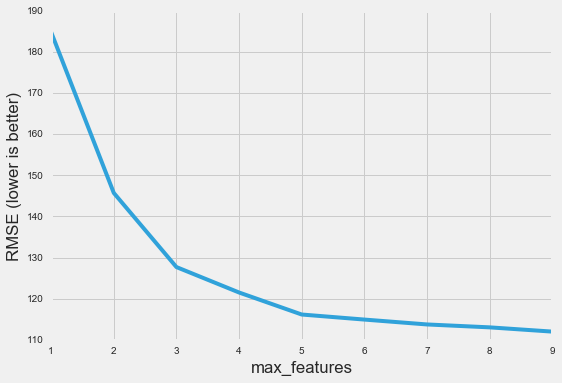

In [42]:
# plot n_estimators (x-axis) versus RMSE (y-axis)
plt.plot(features, RMSE_scores)
plt.xlabel('max_features')
plt.ylabel('RMSE (lower is better)')

In [43]:
pd.DataFrame({'feature':poly_cols_names, 'importance':rfp.feature_importances_}).sort_values(by='importance',ascending=False)

,feature,importance
31,None,0.121116
4,None,0.101419
1,None,0.086987
20,None,0.085907
19,None,0.074812
32,None,0.070104
17,None,0.064994
22,None,0.038361
2,None,0.035435
24,None,0.032520


### Cross Validation - random forest

In [44]:
# STANDARD - accuracy
cross_val_scores = cross_val_score(rf,X,y,cv=10) 
print "10-fold accuracies:\n",cross_val_scores
print "Mean cv-accuracy:",np.mean(cross_val_scores)
print "Std of cv-accuracy:",np.std(cross_val_scores)


10-fold accuracies:
[ 0.8799  0.9249  0.8606  0.9494  0.934   0.8969  0.9169  0.9274  0.9454
  0.8351]
Mean cv-accuracy: 0.907065035114
Std of cv-accuracy: 0.0360628493427


In [45]:
# POLYNOMIAL - accuracy
cross_val_scoresp = cross_val_score(rfp,Xp,yp,cv=10) # computer blows up > 10 folds
print "10-fold accuracies - poly:\n",cross_val_scoresp
print "Mean cv-accuracy - poly:",np.mean(cross_val_scoresp)
print "Std of cv-accuracy - poly:",np.std(cross_val_scoresp)

10-fold accuracies - poly:
[ 0.8644  0.9254  0.8563  0.9496  0.9256  0.8927  0.9094  0.9225  0.9378
  0.8293]
Mean cv-accuracy - poly: 0.901308517044
Std of cv-accuracy - poly: 0.0374189056582


In [46]:
# STANDARD - RMSE
cross_val_scores = cross_val_score(rf,X,y,cv=10, scoring='mean_squared_error')
print "10-fold mse's:\n",cross_val_scores,"\n"

print "Mean cv-mse:",np.mean(cross_val_scores),"\n"

print "10-fold rmse's:\n",np.sqrt(np.abs(cross_val_scores)),"\n"

print "Mean cv-rmse:\n",np.sqrt(np.abs(cross_val_scores)).mean()

10-fold mse's:
[-18349.4548 -12687.552  -24538.9877  -8106.135  -10438.5688 -16126.3984
 -12340.8041 -11031.0422  -9026.4173 -29121.115 ] 

Mean cv-mse: -15176.6475153 

10-fold rmse's:
[ 135.4602  112.639   156.6493   90.0341  102.1693  126.9898  111.0892
  105.0288   95.0075  170.6491] 

Mean cv-rmse:
120.571609019


In [47]:
# POLYNOMIAL - RMSE
cross_val_scoresp = cross_val_score(rfp,Xp,yp,cv=10, scoring='mean_squared_error')
print "10-fold mse's:\n",cross_val_scores,"\n"

print "Mean cv-mse:",np.mean(cross_val_scoresp),"\n"

print "10-fold rmse's:\n",np.sqrt(np.abs(cross_val_scoresp)),"\n"

print "Mean cv-rmse:\n",np.sqrt(np.abs(cross_val_scoresp)).mean()

10-fold mse's:
[-18349.4548 -12687.552  -24538.9877  -8106.135  -10438.5688 -16126.3984
 -12340.8041 -11031.0422  -9026.4173 -29121.115 ] 

Mean cv-mse: -16183.3157148 

10-fold rmse's:
[ 146.3543  112.1033  158.3824   90.3313  107.9815  129.1392  117.2042
  110.4867  101.74    173.1173] 

Mean cv-rmse:
124.684018726


<a id='Evaluation'></a>
## Evaluate Models

** I wasn't able to complete: **
* cross validation with other models
* setting up CV-grid
* setting up the model evaluation AUC / ROC models from last class

** I found the following that I was surprised about: **
* skewed vs unskewed data didn't make as much difference as I'd expect (the data is fairly skewed)
* polynomical expansion:
    * improved linear regression alot (not unexpected)
    * had little impact on random forest (??)
* linear model (train | test) with polynomial expansion performs really well...about as well as Cross Validated Random Forest with / without polynomial expansion
* random forest with polynomial expansion still optimizes (best I can tell) only ~6 features.  Same if not slightly less than the non expanded set.
* DegreeDays has basically no impact on the model (??) Felt this was very strange given its a climate indicator and heating and cooling cost (everything else being equal) should tavel with this number

** Best Model ** 
When I used 60k random samples (takes a while to run) but with the same settings in the models here, I found:
* Linear Regression w/ Polynomials Test | Train --> RMSE ~ 110
* Single Decision Trees Test | train --> RMSE as low as 115
* Random Forest Cross Validated w/ Polynomials was in between and without performed slightly worse

#### overall, that means we could get within ~110 USD on average of the actual energy costs - not bad!
* costs should be a mix of these 5 things
    * home size (sqft, beds, etc)
    * home construction quality | materials details (style, year of construction / remodel as proxy)
    * climate (DegreeDays should be a proxy for this)
    * consumption pattern (what do you set your thermostat for?) (out of scope)
    * energy costs per unit (out of scope)
    
Given the number of items out of scope, I think the estimatation here is "decent" but not great.
  

** Best Model ALTERYX **
The alteryx models all outperformed the Sklearn models.  I'm sure it has to do with settings, but not sure where. 

For skewed data:
* Random Forest as low as --> RMSE 24
* Booted Model as low as --> RMSE 45

For unskewed data: RMSE results are on average 10% **worse**

NOTE: I didn't look into how to import the polynomials to Alteryx.  However some of their models let you specify the level of "interactions" which I defined as 2 and believe is the same thing.